<a href="https://colab.research.google.com/github/kaggle-team/IEEE-Fraud-Detection/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Loading data from Google Drive'''

from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import pandas as pd
import numpy as np

# For graphs
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('ggplot')

In [0]:
!unzip -q "/content/gdrive/My Drive/Kaggle/IEEE-Fraud-Detection.zip"


In [0]:
files_path = "/content/"
train_identity_path = os.path.join(files_path, 'train_identity.csv')
train_transaction_path = os.path.join(files_path, 'train_transaction.csv')
test_identity_path = os.path.join(files_path, 'test_identity.csv')
test_transaction_path = os.path.join(files_path, 'test_transaction.csv')

In [0]:
train_identity = pd.read_csv(train_identity_path)
train_transaction = pd.read_csv(train_transaction_path)
test_identity = pd.read_csv(test_identity_path)
test_transaction = pd.read_csv(test_transaction_path)

In [0]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
del train_identity, train_transaction, test_identity, test_transaction

In [0]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [0]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,...,13.103775,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,...,106.739813,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+0

In [0]:
print("Train set:",train.shape[0],'obs', sum(train.isFraud), 'frauds','\n', "Test set:",test.shape[0],'obs')

Train set: 590540 obs 20663 frauds 
 Test set: 506691 obs


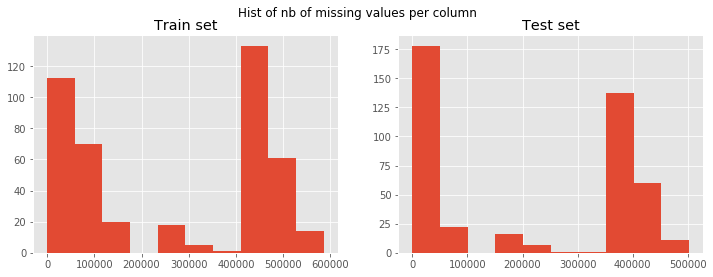

In [9]:
missing_train = train.isna().sum()
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(1,2,1)
ax.hist(missing_train)
ax.set_title("Train set")

ax2 = fig.add_subplot(1,2,2)
ax2.hist(test.isna().sum())
ax2.set_title("Test set")

plt.suptitle("Hist of nb of missing values per column")
plt.show()

In [10]:
missing_test = test.isna().sum()
high_missing_train = list(missing_train[missing_train/len(train)>0.8].keys())
high_missing_test = list(missing_test[missing_test/len(test)>0.8].keys())
both = set(high_missing_train+high_missing_test)
print(len(high_missing_train),len(both))
# il se trouve que toutes les colonnes qui ont >80% de nan dans le fichier test, ont >80% de mising values dans train.
# Pour un premier modèle, on delete juste ces colonnes

74 74


In [11]:
train.drop(high_missing_train, axis = 1, inplace = True)
test.drop(high_missing_train, axis = 1, inplace = True)
print(train.shape, test.shape)


(590540, 360) (506691, 359)


#<font color='red'> **Premier test: XgBoost**

In [0]:
from sklearn import preprocessing
import xgboost as xgb

In [0]:
y_train = train['isFraud'].copy()

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

In [22]:
sum(y_train)/len(y_train)

0.03499000914417313

In [0]:
del train, test


## Reduce memory

In [0]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
#            # Print new column type
#            print("dtype after: ",df[col].dtype)
#            print("******************************")
#    # Print final result
#    print("___MEMORY USAGE AFTER COMPLETION:___")
#    mem_usg = df.memory_usage().sum() / 1024**2 
#    print("Memory usage is: ",mem_usg," MB")
#    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [0]:
train, NAlist = reduce_mem_usage(X_train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [0]:
test, NAlist = reduce_mem_usage(test)


In [0]:
# Label Encoding: passe qualitatives en quantitatives discrètes

for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

In [0]:
tuned_parameters= {'colsample_bytree': [0.8,0.9,1], 'learning_rate': [0.05,0.1,0.15], 'grow_policy': ['depthwise, lossguide']} 

clf =  GridSearchCV(xgb.XGBClassifier(n_estimators=500,
                                      n_jobs=4,
                                      max_depth=9,
                                  #    learning_rate=0.05,
                                      subsample=0.9,
                                      scale_pos_weight = sum(y_train)/len(y_train)
                                  #    colsample_bytree=0.9,
                                      objective = 'binary:hinge',
                                      eval_metric='error',
                                      missing=-999),
                    tuned_parameters,
                    cv = 5,
                    scoring = 'error'

clf.fit(X_train, y_train, verbose = True)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
                    
                    

In [0]:
sample_submission = pd.read_csv(train_identity_path = os.path.join(files_path, 'train_identity.csv'))


In [0]:
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('simple_xgboost.csv')

id_30 = operating sistem

id_31 = browser

id_33 = screen resolution

train / test has been split by time

what's the difference of Pemaildomain and Remaildomain?: P-Purchaser; R-Recipient

https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480

https://www.kaggle.com/c/ieee-fraud-detection/discussion/99993#latest-579834

https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

**Cleaning P_emaildomain and R_emaildomain:** https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-580176

**simple XGBOOST kernel:** https://www.kaggle.com/inversion/ieee-simple-xgboost

**reduce memory size:** https://www.kaggle.com/mjbahmani/reducing-memory-size-for-ieee

**column reference:** https://www.kaggle.com/alijs1/ieee-transaction-columns-reference

**recap des top kernels de concours:** https://www.kaggle.com/jazivxt/top-private-leaderboard-kernels

**insight sur les variables:** https://www.kaggle.com/jesucristo/fraud-complete-eda